# Lining up the Data and Splitting it
* This section is to find the data that we have the moment, converting it to 256x256 resolution, then dividing into train, validation, and test set

In [ ]:
import torch
from torch import optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import random
from dotenv import load_dotenv
import torch.nn as nn
from torchvision import transforms, models
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
import h5py
from scipy.stats import pearsonr

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#smaller 3.14GB hdf5 file path:
small_path = '/content/drive/MyDrive/dsc180/data/bnpp_frontalonly_1024_10.hdf5'
# larger 11GB hdf5 file path:
large_path = '/content/drive/MyDrive/dsc180/data/bnpp_frontalonly_1024_9.hdf5'
# CSV Files:
train_data = '/content/drive/MyDrive/dsc180/data/BNPP_DT_train_with_ages.csv'
val_data = '/content/drive/MyDrive/dsc180/data/BNPP_DT_val_with_ages.csv'
test_data = '/content/drive/MyDrive/dsc180/data/BNPP_DT_test_with_ages.csv'

In [ ]:
def grab_keys(path, lst):
    with h5py.File(path, 'r') as f:
        lst.extend(list(f.keys()))

img_keys = []
grab_keys(small_path, img_keys)
print(len(img_keys))
grab_keys(large_path, img_keys)
print(len(img_keys))

749
3449


In [ ]:
train_df, val_df, test_df = pd.read_csv(train_data), pd.read_csv(val_data), pd.read_csv(test_data)
desired_cols = train_df.columns
# consistency in columsn
train_df = train_df[desired_cols].set_index('unique_key')
val_df = val_df[desired_cols].set_index('unique_key')
test_df = test_df[desired_cols].set_index('unique_key')

In [ ]:
def find_data_from_dataframe(img_keys, train_df, val_df, test_df):
    """
    Keep the keys that are in the train_df, val_df, or test_df
    """
    # find the intersection of the train_df and img_keys to keep them
    train_df = train_df.loc[train_df.index.intersection(img_keys)]
    val_df = val_df.loc[val_df.index.intersection(img_keys)]
    test_df = test_df.loc[test_df.index.intersection(img_keys)]


    return train_df, val_df, test_df

In [ ]:
# --- Find the data we need to keep ---
train_df, val_df, test_df = find_data_from_dataframe(img_keys, train_df, val_df, test_df)

In [ ]:
len(train_df), len(val_df), len(test_df)

(2634, 329, 331)

In [ ]:
def shrink_image(arr):
    # downsample by taking mean over 4×4 blocks
    return arr.reshape(256, 4, 256, 4).mean(axis=(1, 3))

def add_image_data_df(df, small_path, large_path):
    with h5py.File(small_path, 'r') as f_small, h5py.File(large_path, 'r') as f_large:

        all_images = {}

        for key in set(f_small.keys()) | set(f_large.keys()):
            if key in f_small:
                arr = f_small[key][:]
            elif key in f_large:
                arr = f_large[key][:]
            else:
                arr = np.nan

            # ✅ Apply shrinking if array loaded successfully
            if isinstance(arr, np.ndarray) and arr.size > 0:
                arr = shrink_image(arr)

            all_images[key] = arr

    df['img_arr'] = df.index.map(lambda k: all_images.get(k, np.nan))
    return df


In [ ]:
train_df = add_image_data_df(train_df, small_path, large_path)
val_df = add_image_data_df(val_df, small_path, large_path)
test_df = add_image_data_df(test_df, small_path, large_path)

In [ ]:
train_df.head(5)

,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime,img_arr
unique_key,,,,,,,
Wimune_51412581_img1,0.690196,1,NaN,1,4.9,51,"[[12718.283, 11885.4375, 11299.322, 10558.078,..."
Tetotuf_50268500_img1,0.690196,1,NaN,1,4.9,34,"[[1093.0479, 1741.9003, 1966.624, 2180.717, 24..."
Tajisi_50187953_img1,0.690196,1,NaN,1,4.9,64,"[[10647.469, 8578.069, 6712.6006, 5189.365, 43..."
Sugoda_51704488_img1,0.690196,1,NaN,1,4.9,67,"[[2565.1519, 2565.5066, 2423.3066, 2391.5972, ..."
Srobosop_51367283_img1,0.690196,1,NaN,1,4.9,42,"[[1390.2167, 1981.6113, 2631.791, 2957.7244, 3..."


# Data Preprocessing:
* This part will convert the data into a usable format - pytorch tensors.

In [ ]:
X_train = np.stack(train_df['img_arr'])
X_val = np.stack(val_df['img_arr'])
X_test = np.stack(test_df['img_arr'])

### Standardizing the outputs

In [ ]:
y_train = np.array(train_df['bnpp_value_log'])
y_val = np.array(val_df['bnpp_value_log'])
y_test = np.array(test_df['bnpp_value_log'])

# --- Standardize using TRAIN set statistics ---
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std   # use train mean/std!
y_test = (y_test - y_mean) / y_std

print(f"y_train mean: {y_train.mean():.3f}, std: {y_train.std():.3f}")
print(f"y_val mean: {y_val.mean():.3f}, std: {y_val.std():.3f}")
print(f"y_test mean: {y_test.mean():.3f}, std: {y_test.std():.3f}")


y_train mean: 0.000, std: 1.000
y_val mean: -0.037, std: 1.106
y_test mean: -0.001, std: 0.925


### 3) Define Transform (Downsample + Normalize)

In [ ]:
from torchvision import transforms

train_transfrom = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=5,),
    transforms.ToTensor(),                   # gives [0,1] float
    transforms.Normalize(                    # ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                   # gives [0,1] float
    transforms.Normalize(                    # ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])




### 4) Create Data Class (for the arrays)

In [ ]:
class XRayDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)

        # 1️⃣  Scale to [0,1] only if not already
        if image.max() > 1:
            image /= image.max()

        # 2️⃣  Convert grayscale → 3-channel tensor manually
        image = np.stack([image]*3, axis=-1)   # H×W×3

        # 3️⃣  Convert to PIL Image (float32 is fine)
        pil_image = Image.fromarray((image * 255).astype(np.uint8))

        # 4️⃣  Apply standard VGG16 transform
        if self.transform:
            pil_image = self.transform(pil_image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32).view(-1)
        return pil_image, label


### 5) Being W&B and Training
1) Call Model
2) Configure

In [ ]:
# --- Model Setup for REGRESSION ---
model = models.vgg16(weights='IMAGENET1K_V1')

# -- Freeze the weights in model
for p in model.features.parameters():
    p.requires_grad = False

# --- Regression Head (simplified but expressive) ---
model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
)




In [ ]:
config = {
    "learning_rate": 1e-5,            # fixed LR (as in paper)
    "epochs": 50,                     # match paper exactly
    "batch_size": 16,                 # as reported
    "architecture": "VGG16 X-ray Regression",
    "criterion": "L1Loss",            # same as paper
    "optimizer": "Adam",              # match "Adam" from paper (not AdamW)
    "weight_decay": 0.0,              # paper didn’t mention L2 regularization
    "dropout": 0.3,                   # fine; mild regularization helps
    "scheduler": None,                # fixed LR → no scheduler
    "unfreeze_last_block": False,     # paper likely kept backbone frozen
    "save_best_metric": "val_pearson_r"
}



In [ ]:
wandb.login()
wandb.init(project="dsc180-recreate-vgg16", config=config)
wandb.watch(model, log="all", log_freq=100)

# Training

## Using the MAE Variant (used in Paper)

In [ ]:
# --- Create Datasets & DataLoaders ---
train_dataset = XRayDataset(images=X_train, labels=y_train, transform= train_transfrom )
val_dataset = XRayDataset(images=X_val, labels=y_val, transform=transform)
test_dataset = XRayDataset(images=X_test, labels=y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

In [ ]:
# --- 2. Model & Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
# --- Correlation Loss Function ---
def corr_loss(pred, target):
    """
    Compute (1 - Pearson correlation) loss between predicted and true values.
    Encourages higher correlation structure.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    vx = pred - pred.mean()
    vy = target - target.mean()
    denom = (vx.std() * vy.std()) + 1e-8  # numerical stability
    corr = (vx * vy).mean() / denom
    corr = torch.clamp(corr, -1.0, 1.0)
    return 1 - corr  # maximize corr → minimize (1 - corr)


# --- Training Loop ---
for epoch in range(config["epochs"]):
    model.train()
    train_loss_total = 0.0
    all_train_preds, all_train_labels = [], []

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        mae_loss = criterion(outputs, labels.view(-1, 1))
        c_loss = corr_loss(outputs, labels.view(-1, 1))

        # Combine both losses
        total_loss = 0.9 * mae_loss + 0.1 * c_loss

        total_loss.backward()
        optimizer.step()
        train_loss_total += total_loss.item()

        # --- Collect for train r ---
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.detach().cpu())

        # Log batch-level loss occasionally
        if step % 50 == 0:
            wandb.log({
                "batch_train_loss": total_loss.item(),
                "mae_loss": mae_loss.item(),
                "corr_loss": c_loss.item(),
                "step": epoch * len(train_loader) + step
            })

    avg_train_loss = train_loss_total / len(train_loader)

    # --- Compute Training Pearson r ---
    all_train_preds = torch.cat(all_train_preds).numpy()
    all_train_labels = torch.cat(all_train_labels).numpy()
    train_r, _ = pearsonr(all_train_labels.flatten(), all_train_preds.flatten())

    # --- Validation ---
    model.eval()
    val_loss_total = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for val_step, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss_total += criterion(outputs, labels.view(-1, 1)).item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_val_loss = val_loss_total / len(val_loader)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    val_r, _ = pearsonr(all_labels.flatten(), all_preds.flatten())

    # --- Scatter Plot ---
    fig, ax = plt.subplots()
    ax.scatter(all_labels, all_preds, alpha=0.5)
    ax.set_xlabel("True BNP (log)")
    ax.set_ylabel("Predicted BNP (log)")
    ax.set_title(f"Epoch {epoch+1} Predictions vs True")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_mae": avg_val_loss,
        "train_pearson_r": train_r,
        "val_pearson_r": val_r,
        "pred_vs_true": wandb.Image(fig)
    })
    plt.close(fig)

    # --- Scheduler step (if used) ---
    if 'scheduler' in locals() and scheduler is not None:
        scheduler.step()
        wandb.log({"lr": scheduler.get_last_lr()[0]})

    print(f"Epoch {epoch+1}/{config['epochs']} | "
          f"Train Loss: {avg_train_loss:.4f} | Train r: {train_r:.4f} | "
          f"Val MAE: {avg_val_loss:.4f} | Val r: {val_r:.4f}")

wandb.finish()
print("Training finished!")


Epoch 1/50 | Train Loss: 0.2884 | Train r: 0.9070 | Val MAE: 2.1538 | Val r: -0.0200
Epoch 2/50 | Train Loss: 0.7624 | Train r: 0.0969 | Val MAE: 2.0331 | Val r: 0.0096
Epoch 3/50 | Train Loss: 0.8078 | Train r: 0.0504 | Val MAE: 1.9039 | Val r: 0.0775
Epoch 4/50 | Train Loss: 0.8975 | Train r: -0.0814 | Val MAE: 1.8852 | Val r: 0.1487
Epoch 5/50 | Train Loss: 0.8957 | Train r: -0.0509 | Val MAE: 1.8226 | Val r: 0.2122
Epoch 6/50 | Train Loss: 0.8610 | Train r: -0.0105 | Val MAE: 1.9233 | Val r: 0.1983
Epoch 7/50 | Train Loss: 0.8568 | Train r: 0.0099 | Val MAE: 1.6516 | Val r: 0.3269
Epoch 8/50 | Train Loss: 0.7857 | Train r: 0.1639 | Val MAE: 1.6957 | Val r: 0.3334
Epoch 9/50 | Train Loss: 0.8271 | Train r: 0.0905 | Val MAE: 1.7034 | Val r: 0.3587
Epoch 10/50 | Train Loss: 0.8199 | Train r: 0.1129 | Val MAE: 1.7750 | Val r: 0.3440
Epoch 11/50 | Train Loss: 0.7741 | Train r: 0.1602 | Val MAE: 1.6226 | Val r: 0.3630
Epoch 12/50 | Train Loss: 0.8100 | Train r: 0.1211 | Val MAE: 1.5231 |

batch_train_loss,▁█▂▁▂▇▂▁▁▂▁▂▁▁▁▇▂▁▂▁▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▆▆▁
corr_loss,▅▆▃▁▅▅▄▅▃▅▅▂█▇▃▅▆▁▃▇▁▆▆█▃█▃▆▄▃▃▇▄▄▂▃▇▃▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
mae_loss,▁▁▁██▁▁▇▇▁▁▁▁▁▂▇▂▇▂▂▂▁▁▇▁▂▆▁▆▆▂▁▆▂▁▂▁▁▁▁
step,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,▁▆▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅
train_pearson_r,█▂▂▁▁▂▃▂▂▃▂▃▃▃▃▃▃▃▃▃▄▃▃▃▃▄▄▄▄▅▅▄▅▄▅▄▄▄▄▅
val_mae,█▇▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▂
val_pearson_r,▁▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇█▇████████████████
batch_train_loss,0.39581
corr_loss,0.71879


Training finished!


Test MAE (log-space): 1.2151
Test Pearson r: 0.4614, p-value: 7.381e-19
0.48003435 0.92535007


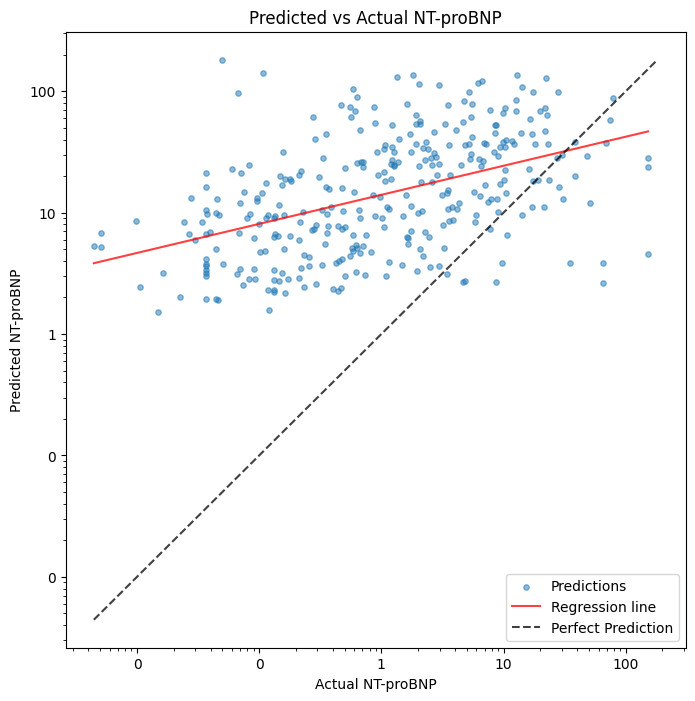

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import torch
import matplotlib.ticker as ticker
import wandb


model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_test_preds.extend(outputs.cpu().numpy().flatten())
        all_test_labels.extend(labels.cpu().numpy().flatten())

# Convert to numpy arrays
all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)

# --- Compute MAE in log-space (since model predicts log values) ---
test_mae_log = mean_absolute_error(all_test_labels, all_test_preds)
print(f"Test MAE (log-space): {test_mae_log:.4f}")

# --- Undo log transform to original BNP scale ---
y_test_pred = 10 ** all_test_preds
y_test_true = 10 ** all_test_labels

# --- Pearson correlation ---
r, p_value = pearsonr(all_test_labels, all_test_preds)
print(f"Test Pearson r: {r:.4f}, p-value: {p_value:.4g}")

# --- Simple scatter plot with regression line ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test_true, y_test_pred, alpha=0.5, label='Predictions', s=15)

# Fit a regression line in log10 space
log_true = np.log10(y_test_true).reshape(-1, 1)
log_pred = np.log10(y_test_pred)
reg = LinearRegression().fit(log_true, log_pred)
reg_line = 10 ** reg.predict(log_true)
ax.plot(y_test_true, reg_line, 'r-', alpha=0.75, label='Regression line')
print(np.std(all_test_preds), np.std(all_test_labels))


# Reference y = x (perfect prediction)
lims = [min(y_test_true.min(), y_test_pred.min()), max(y_test_true.max(), y_test_pred.max())]
ax.plot(lims, lims, 'k--', alpha=0.75, label='Perfect Prediction')

ax.set_xlabel("Actual NT-proBNP")
ax.set_ylabel("Predicted NT-proBNP")
ax.set_title("Predicted vs Actual NT-proBNP")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

# Format axes for readability
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='both')
ax.tick_params(axis='both', which='major', labelsize=10)



plt.show()
wandb.finish()
plt.close(fig)


### Investigating Residuals for MAE Loss:
* Helpful to see where the model might struggle

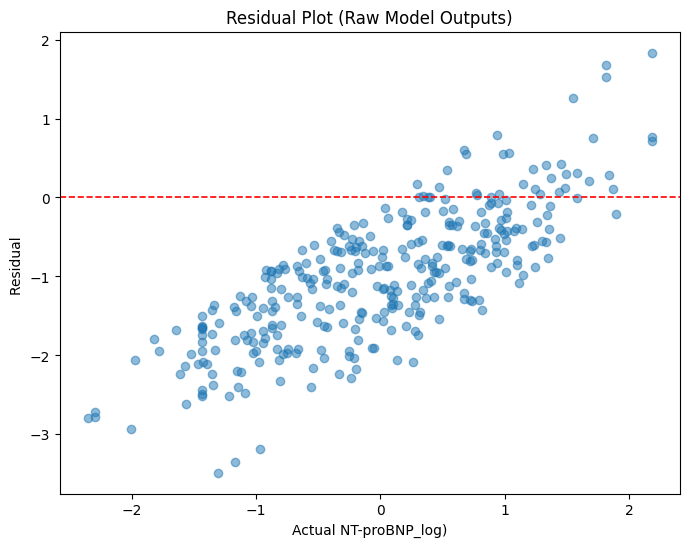

In [ ]:
import matplotlib.ticker as ticker

# Compute residuals in *linear space*
residuals = all_test_labels - all_test_preds

# --- Plot residuals ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(all_test_labels, residuals, alpha=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=1.2)

# Keep log scale on x-axis (NT-proBNP spans wide range)

ax.set_xlabel("Actual NT-proBNP_log)")
ax.set_ylabel("Residual ")
ax.set_title("Residual Plot (Raw Model Outputs)")

# Keep ticks clean
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')


# Log to W&B if run active
if wandb.run is not None:
    wandb.log({"test_residual_plot_linear": wandb.Image(fig)})

plt.show()
plt.close(fig)


### Conclusions on MAE Loss Model:
It appears that our current model can't predict values that are low (predicted_val > actual_val) and high values(predicted_val < actual). That means our model might need some tweaking to help handle this issue
* Potential Solution #1: Huber Loss?

## Training with Huber Loss

In [ ]:
# --- 1. Config ---
config = {
    "learning_rate": 1e-5,            # fixed LR (as in paper)
    "epochs": 50,                     # match paper exactly
    "batch_size": 16,                 # as reported
    "architecture": "VGG16 X-ray Regression",
    "criterion": "Huber",
    "optimizer": "Adam",              # match "Adam" from paper (not AdamW)
    "weight_decay": 0.0,              # paper didn’t mention L2 regularization
    "dropout": 0.4,                   # fine; mild regularization helps
    "scheduler": None,                # fixed LR → no scheduler
    "unfreeze_last_block": False,     # paper likely kept backbone frozen
    "save_best_metric": "val_pearson_r"
}

wandb.init(project="dsc180-recreate-vgg16-huber", config=config)

# --- 2. Model Setup for REGRESSION---
huber_model = models.vgg16(weights='IMAGENET1K_V1')
for param in huber_model.features.parameters(): # freezes the convulitional backbone
    param.requires_grad = False

# Replace the classifier entirely
huber_model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
)


batch_train_loss,█▁▁▁
step,▁▃▆█
batch_train_loss,0.01394
step,150


In [ ]:
# --- 2. Model & Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
huber_model.to(device)
criterion = nn.HuberLoss()
optimizer = optim.Adam(huber_model.classifier.parameters(), lr=config["learning_rate"])

In [ ]:
wandb.watch(huber_model, log="all", log_freq=100)


In [ ]:
from scipy.stats import pearsonr

# --- Training Loop ---
for epoch in range(config["epochs"]):
    huber_model.train()
    train_loss_total = 0.0
    all_train_preds, all_train_labels = [], []

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = huber_model(images)

        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()

        # --- Collect predictions for train r ---
        all_train_preds.append(outputs.detach().cpu())
        all_train_labels.append(labels.detach().cpu())

        # Log batch-level loss occasionally
        if step % 50 == 0:
            wandb.log({
                "batch_train_loss": loss.item(),
                "step": epoch * len(train_loader) + step
            })

    avg_train_loss = train_loss_total / len(train_loader)

    # --- Compute Training Pearson r ---
    all_train_preds = torch.cat(all_train_preds).numpy()
    all_train_labels = torch.cat(all_train_labels).numpy()
    train_r, _ = pearsonr(all_train_labels.flatten(), all_train_preds.flatten())

    # --- Validation ---
    huber_model.eval()
    val_loss_total = 0.0
    all_preds = []
    all_labels = []
    sample_images = []
    sample_labels = []

    with torch.no_grad():
        for val_step, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = huber_model(images)
            val_loss_total += criterion(outputs, labels.view(-1,1)).item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

            # store first batch for logging
            if val_step == 0:
                sample_images = images[:5].cpu()
                sample_labels = labels[:5].cpu()

    avg_val_loss = val_loss_total / len(val_loader)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    val_r, _ = pearsonr(all_labels.flatten(), all_preds.flatten())

    # --- Predictions vs True Scatter Plot ---
    fig, ax = plt.subplots()
    ax.scatter(all_labels, all_preds, alpha=0.5)
    ax.set_xlabel("True BNP (log)")
    ax.set_ylabel("Predicted BNP (log)")
    ax.set_title(f"Epoch {epoch+1} Predictions vs True")
    wandb.log({
        "epoch": epoch+1,
        "val_huber_loss": avg_val_loss,
        "train_loss": avg_train_loss,
        "train_pearson_r": train_r,
        "val_pearson_r": val_r,
        "pred_vs_true": wandb.Image(fig)
    })
    plt.close(fig)

    # --- Log sample images with predictions ---
    for i in range(len(sample_images)):
        wandb.log({
            "sample_xray": wandb.Image(
                sample_images[i],
                caption=f"True: {sample_labels[i].item():.2f}, Pred: {all_preds[i][0]:.2f}"
            )
        })

    print(f"Epoch {epoch+1}/{config['epochs']} | "
          f"Train Huber: {avg_train_loss:.4f} | Train r: {train_r:.4f} | "
          f"Val Huber: {avg_val_loss:.4f} | Val r: {val_r:.4f}")

wandb.finish()
print("Training finished!")


wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


Epoch 1/50 | Train Huber: 0.0648 | Train r: 0.9191 | Val Huber: 1.6415 | Val r: -0.0080
Epoch 2/50 | Train Huber: 0.3105 | Train r: 0.4285 | Val Huber: 1.6960 | Val r: -0.0465
Epoch 3/50 | Train Huber: 0.2957 | Train r: 0.4492 | Val Huber: 1.6297 | Val r: -0.0534
Epoch 4/50 | Train Huber: 0.3424 | Train r: 0.3587 | Val Huber: 1.4748 | Val r: -0.0097
Epoch 5/50 | Train Huber: 0.3940 | Train r: 0.2554 | Val Huber: 1.4181 | Val r: 0.0272
Epoch 6/50 | Train Huber: 0.4014 | Train r: 0.2453 | Val Huber: 1.3471 | Val r: 0.0429
Epoch 7/50 | Train Huber: 0.4505 | Train r: 0.0653 | Val Huber: 1.1642 | Val r: 0.1492
Epoch 8/50 | Train Huber: 0.5189 | Train r: -0.1342 | Val Huber: 0.9019 | Val r: 0.3078
Epoch 9/50 | Train Huber: 0.4698 | Train r: 0.0151 | Val Huber: 0.9809 | Val r: 0.3163
Epoch 10/50 | Train Huber: 0.4739 | Train r: -0.0028 | Val Huber: 0.8125 | Val r: 0.3810
Epoch 11/50 | Train Huber: 0.4641 | Train r: 0.0379 | Val Huber: 0.6793 | Val r: 0.4108
Epoch 12/50 | Train Huber: 0.4359 |

batch_train_loss,▁█▁▁▁▂▆▆▁▇▂▅▁▁▁▅▁▂▅▆▁▂▅▁▁▁▁▅▁▁▁▁▅▁▁▁▁▁▅▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
train_loss,▁▅▅▅▆▇█▇▇▇▇▆▇▆▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▅▄▄▄▄▄▄
train_pearson_r,█▅▅▄▄▂▁▂▂▂▃▄▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆
val_huber_loss,███▇▆▅▃▄▃▂▂▄▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▃
val_pearson_r,▂▁▁▂▂▃▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
batch_train_loss,0.15467
epoch,50
step,8235
train_loss,0.2708


Training finished!


### Plotting Regression line for Huber Loss

In [ ]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import torch
import matplotlib.ticker as ticker
import wandb


huber_model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = huber_model(images)
        all_test_preds.extend(outputs.cpu().numpy().flatten())
        all_test_labels.extend(labels.cpu().numpy().flatten())

# Convert to numpy arrays
all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)

# --- Compute MAE in log-space (since model predicts log values) ---
test_mae_log = mean_absolute_error(all_test_labels, all_test_preds)
print(f"Test MAE (log-space): {test_mae_log:.4f}")

# --- Undo log transform to original BNP scale ---
y_test_pred = 10 ** all_test_preds
y_test_true = 10 ** all_test_labels

# --- Pearson correlation ---
r, p_value = pearsonr(all_test_labels, all_test_preds)
print(f"Test Pearson r: {r:.4f}, p-value: {p_value:.4g}")

# --- Simple scatter plot with regression line ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test_true, y_test_pred, alpha=0.5, label='Predictions', s=15)

# Fit a regression line in log10 space
log_true = np.log10(y_test_true).reshape(-1, 1)
log_pred = np.log10(y_test_pred)
reg = LinearRegression().fit(log_true, log_pred)
reg_line = 10 ** reg.predict(log_true)
ax.plot(y_test_true, reg_line, 'r-', alpha=0.75, label='Regression line')
print(np.std(all_test_preds), np.std(all_test_labels))


# Reference y = x (perfect prediction)
lims = [min(y_test_true.min(), y_test_pred.min()), max(y_test_true.max(), y_test_pred.max())]
ax.plot(lims, lims, 'k--', alpha=0.75, label='Perfect Prediction')

ax.set_xlabel("Actual NT-proBNP")
ax.set_ylabel("Predicted NT-proBNP")
ax.set_title("Predicted vs Actual NT-proBNP")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

# Format axes for readability
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='both')
ax.tick_params(axis='both', which='major', labelsize=10)



plt.show()
wandb.finish()
plt.close(fig)



=== Best 3 Predictions (BNP-space) ===
Idx 200: True=1,659, Pred=1,615, Err=44
Idx 211: True=1,924, Pred=1,818, Err=106
Idx 166: True=958, Pred=1,175, Err=217

=== Worst 3 Predictions (BNP-space) ===
Idx 192: True=1,491, Pred=63,245, Err=61,754
Idx 328: True=70,000, Pred=1,492, Err=68,508
Idx 55: True=127, Pred=75,377, Err=75,250


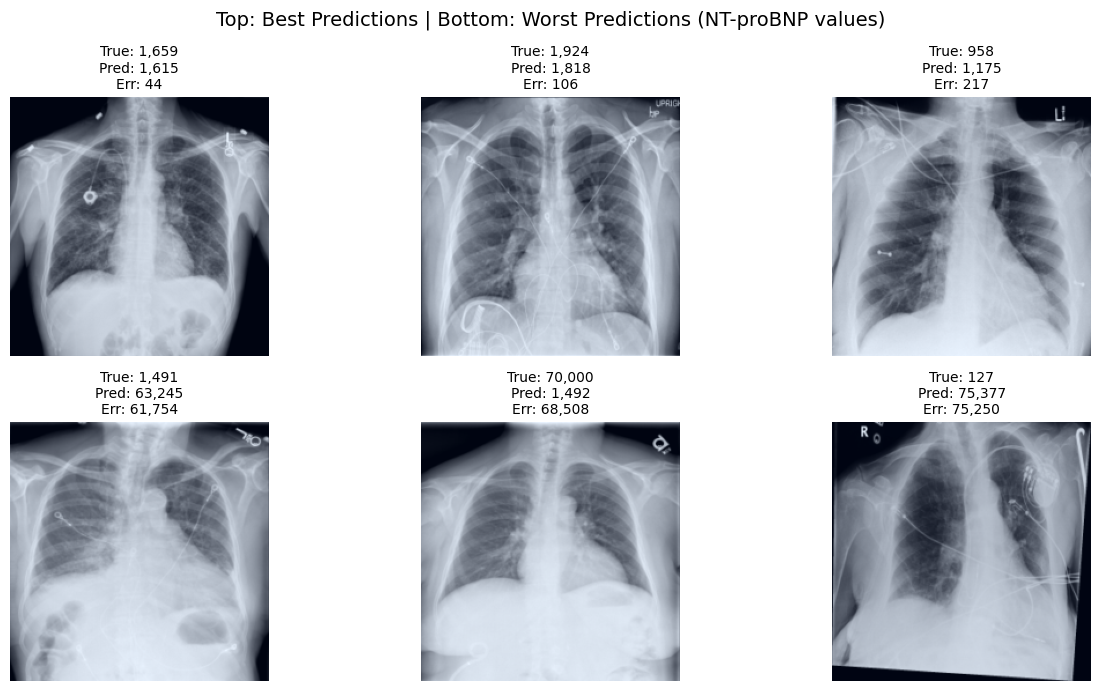

In [ ]:
# --- You should already have saved these from preprocessing ---
# y_mean = y_train.mean()
#  y_std = y_train.std()

# --- Unstandardize predictions and labels ---
all_test_preds_unstd = (all_test_preds * y_std) + y_mean
all_test_labels_unstd = (all_test_labels * y_std) + y_mean

# --- Convert to BNP-space ---
y_test_pred = 10 ** all_test_preds_unstd
y_test_true = 10 ** all_test_labels_unstd

# --- Compute absolute errors in BNP-space ---
errors = np.abs(y_test_pred - y_test_true)

# --- Find indices of best (lowest error) and worst (highest error) ---
best_indices = np.argsort(errors)[:3]
worst_indices = np.argsort(errors)[-3:]

print("\n=== Best 3 Predictions (BNP-space) ===")
for idx in best_indices:
    print(f"Idx {idx}: True={y_test_true[idx]:,.0f}, Pred={y_test_pred[idx]:,.0f}, Err={errors[idx]:,.0f}")

print("\n=== Worst 3 Predictions (BNP-space) ===")
for idx in worst_indices:
    print(f"Idx {idx}: True={y_test_true[idx]:,.0f}, Pred={y_test_pred[idx]:,.0f}, Err={errors[idx]:,.0f}")

# --- Visualization helper ---
def show_case(dataset, idx, pred, true, error):
    image, _ = dataset[idx]
    img = image.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true:,.0f}\nPred: {pred:,.0f}\nErr: {error:,.0f}", fontsize=10)
    plt.axis("off")

# --- Plot best and worst ---
fig, axes = plt.subplots(2, 3, figsize=(13, 7))

for i, idx in enumerate(best_indices):
    plt.sca(axes[0, i])
    show_case(test_dataset, idx, y_test_pred[idx], y_test_true[idx], errors[idx])
axes[0, 0].set_ylabel("Best", fontsize=12)

for i, idx in enumerate(worst_indices):
    plt.sca(axes[1, i])
    show_case(test_dataset, idx, y_test_pred[idx], y_test_true[idx], errors[idx])
axes[1, 0].set_ylabel("Worst", fontsize=12)

plt.suptitle("Top: Best Predictions | Bottom: Worst Predictions (NT-proBNP values)", fontsize=14)
plt.tight_layout()
plt.show()


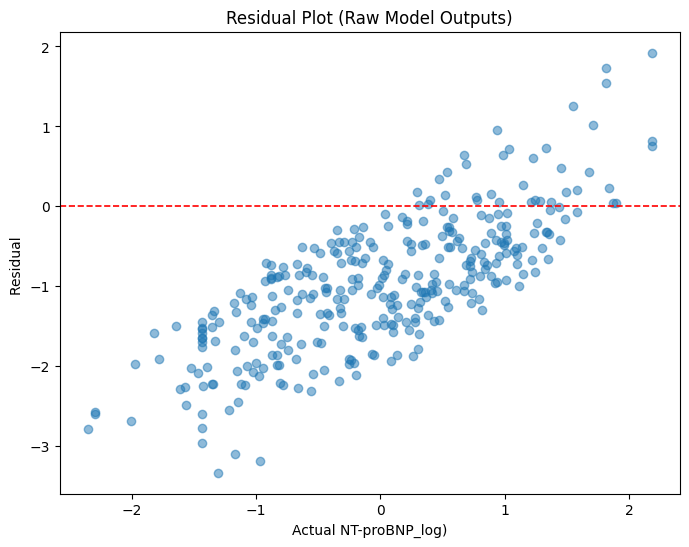

In [ ]:
import matplotlib.ticker as ticker

# Compute residuals in *linear space*
residuals = all_test_labels - all_test_preds

# --- Plot residuals ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(all_test_labels, residuals, alpha=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=1.2)

# Keep log scale on x-axis (NT-proBNP spans wide range)

ax.set_xlabel("Actual NT-proBNP_log)")
ax.set_ylabel("Residual ")
ax.set_title("Residual Plot (Raw Model Outputs)")

# Keep ticks clean
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')


# Log to W&B if run active
if wandb.run is not None:
    wandb.log({"test_residual_plot_linear": wandb.Image(fig)})

plt.show()
plt.close(fig)


## Locating the Best and Worse Predictions